# Notebook de Análise Exploratória dos dados

## Definição do Problema

Utilizar padrões de comportamento de **consumo de energia** para definir e entender perfis de consumidores no Reino Unido, correlacionando esses padrões com fatores socioeconómicos específicos. 

#### Criação de um objeto spark

In [29]:
# Fazer as importações necessárias  
import findspark, pyspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col, lag, first, expr, avg, when 
from pyspark.sql.functions import format_number, count, lit, round
from pyspark.sql.functions import to_date, max as spark_max, first
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler,StringIndexer,OneHotEncoder

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Criar uma sessão Spark
spark = SparkSession\
        .builder\
        .appName("EnergyHouseholdsAnalysis")\
        .config("spark.sql.shuffle.partitions",6)\
        .config("spark.sql.repl.eagereval.enabled",True)\
        .getOrCreate()

In [30]:
spark

#### Carregar os dados provenientes do notebook prévio 

In [31]:
pwd

'/home/jovyan/code/Projeto/Notebooks'

In [32]:
#Ler o dataset a usar
!ls -la ../Datasets/energy_households_parquet.parquet/

total 41600
drwxr-xr-x 1 jovyan users   4096 Jun 10 20:29 .
drwxrwxrwx 1 root   root    4096 Jun 10 20:41 ..
-rw-r--r-- 1 jovyan users 206864 Jun 10 20:29 part-00000-c34cadf9-06fc-4aeb-8901-3986c21d24c2-c000.snappy.parquet
-rw-r--r-- 1 jovyan users   1628 Jun 10 20:29 .part-00000-c34cadf9-06fc-4aeb-8901-3986c21d24c2-c000.snappy.parquet.crc
-rw-r--r-- 1 jovyan users 206636 Jun 10 20:29 part-00001-c34cadf9-06fc-4aeb-8901-3986c21d24c2-c000.snappy.parquet
-rw-r--r-- 1 jovyan users   1624 Jun 10 20:29 .part-00001-c34cadf9-06fc-4aeb-8901-3986c21d24c2-c000.snappy.parquet.crc
-rw-r--r-- 1 jovyan users 206540 Jun 10 20:29 part-00002-c34cadf9-06fc-4aeb-8901-3986c21d24c2-c000.snappy.parquet
-rw-r--r-- 1 jovyan users   1624 Jun 10 20:29 .part-00002-c34cadf9-06fc-4aeb-8901-3986c21d24c2-c000.snappy.parquet.crc
-rw-r--r-- 1 jovyan users 207078 Jun 10 20:29 part-00003-c34cadf9-06fc-4aeb-8901-3986c21d24c2-c000.snappy.parquet
-rw-r--r-- 1 jovyan users   1628 Jun 10 20:29 .part-00003-c34cadf9-06fc-4aeb-8

In [33]:
ficheiro = "../Datasets/energy_households_parquet.parquet/"

# Ler os dados Parquet
df = spark.read.parquet(ficheiro)
df.show(3)

+------------+----------+-------------+-----------+----------+----------+----------+----------+--------+------------+---------+---------+
|household_id|      date|energy_median|energy_mean|energy_max|energy_std|energy_sum|energy_min|tax_type|acorn_groups|   status|is_summer|
+------------+----------+-------------+-----------+----------+----------+----------+----------+--------+------------+---------+---------+
|   MAC001330|2012-12-31|        0.047|      0.073|      0.21|     0.043|     3.525|     0.046|     Std|     ACORN-Q|Adversity|        0|
|   MAC003980|2013-06-27|        0.109|      0.101|     0.248|     0.066|     4.839|       0.0|     Std|     ACORN-Q|Adversity|        1|
|   MAC001993|2012-08-10|        0.077|      0.111|      0.78|     0.125|     5.327|     0.053|     ToU|     ACORN-N|Adversity|        1|
+------------+----------+-------------+-----------+----------+----------+----------+----------+--------+------------+---------+---------+
only showing top 3 rows



### Exclusão Inicial de Variáveis Sem Relevância


A variável **energy_count** corresponde ao numéro de registos energéticos em determinado dia e residência, e este não é diretamente relevante para entender os padrões de consumo de energia, como tal a variável não apresenta qualquer relevância para o problema.


As variávelis  **date_YEAR**, **date_MONTH**, **date_DAY_OF_WEEK** e **date_WEEK_OF_YEAR** como já se encontra representada pela variável **date** deixam de ser relevantes.

In [34]:
# Remoção de variáveis sem relevância
df = df.drop('energy_count','date_YEAR','date_MONTH','date_DAY_OF_WEEK','date_WEEK_OF_YEAR') #eliminação das colunas "household_id" e "date"

#Novo dataframe sem as variáveis removidas
df.columns

['household_id',
 'date',
 'energy_median',
 'energy_mean',
 'energy_max',
 'energy_std',
 'energy_sum',
 'energy_min',
 'tax_type',
 'acorn_groups',
 'status',
 'is_summer']

In [35]:
# Sumário das colunas numéricas 
cols= df.columns
df.describe(cols).show()

+-------+------------+-------------------+-------------------+------------------+------------------+-----------------+--------------------+--------+------------+-----------+------------------+
|summary|household_id|      energy_median|        energy_mean|        energy_max|        energy_std|       energy_sum|          energy_min|tax_type|acorn_groups|     status|         is_summer|
+-------+------------+-------------------+-------------------+------------------+------------------+-----------------+--------------------+--------+------------+-----------+------------------+
|  count|     2281040|            2281040|            2281040|           2281040|           2281040|          2281040|             2281040| 2281040|     2281040|    2281040|           2281040|
|   mean|        NULL|0.12717955903414171| 0.1744815155134456|0.7416889195410702|0.1490972728197361|8.364159738781508| 0.04812805617329649|    NULL|        NULL|       NULL|0.4267470101357276|
| stddev|        NULL|0.08643989367

##### Análise da variável **date**

In [36]:
#Verificar diferentes dias existentes

df.select("date").distinct().count() #Existem 575 dias diferentes em que foram registados consumos energéticos

575

In [37]:
# Agrupar os dados totais por ano
df.groupBy(F.year("date").alias("date_YEAR")).count().orderBy("date_YEAR", ascending=True).show(truncate=False)

+---------+-------+
|date_YEAR|count  |
+---------+-------+
|2011     |5434   |
|2012     |820202 |
|2013     |1265328|
|2014     |190076 |
+---------+-------+



##### Análise da variável **is_summer**

In [38]:
df_summer = df.filter(col("is_summer") == 1).count()
percentagem_summer = (df_summer/df.count())*100
print(f"Cerca de ", percentagem_summer, "% das observações foram registadas durante os meses mais quentes, enquanto que os restantes", 100-percentagem_summer, "% das observações foram registados nos meses mais frios")

Cerca de  42.67470101357276 % das observações foram registadas durante os meses mais quentes, enquanto que os restantes 57.32529898642724 % das observações foram registados nos meses mais frios


##### Análise das variáveis **tax_type**, **acorn_groups** e **resource_acess**

In [39]:
# Função para observar contagem e percentagem de cada valor de uma variável
def count_percentage_values(df, column):
    # Calcular contagem de valores
    count_values = df.groupBy(column).agg(count("*").alias("contagem"))

    # Calcular total de linhas
    total_rows = df.count()

    # Adicionar coluna com a porcentagem de cada valor
    count_percentage = count_values.withColumn("percentagem (%)", round(col("contagem") / lit(total_rows) * 100, 2))

    # Ordenar por valor para melhor visualização
    count_percentage = count_percentage.orderBy(column)

    # Exibir a tabela
    count_percentage.show()

    # Retornar o DataFrame resultante
    return count_percentage

# Visualização de percentagem de cada valor em "tax_type_index"
print('Contagem e frequência relativa dos valores de tax_type:')
count_percentage_values(df, 'tax_type')

# Visualização de percentagem de cada valor em "status"
print('Contagem e frequência relativa dos valores de status:')
count_percentage_values(df, 'status')

# Visualização de percentagem de cada valor em "acorn_groups"
print('Contagem e frequência relativa dos valores de acorn_groups:')
count_percentage_values(df, 'acorn_groups')

Contagem e frequência relativa dos valores de tax_type:


+--------+--------+---------------+
|tax_type|contagem|percentagem (%)|
+--------+--------+---------------+
|     Std| 1816741|          79.65|
|     ToU|  464299|          20.35|
+--------+--------+---------------+

Contagem e frequência relativa dos valores de status:
+-----------+--------+---------------+
|     status|contagem|percentagem (%)|
+-----------+--------+---------------+
|    ACORN-U|   17902|           0.78|
|  Adversity|  763440|          33.47|
|   Affluent|  879219|          38.54|
|Comfortable|  620479|           27.2|
+-----------+--------+---------------+

Contagem e frequência relativa dos valores de acorn_groups:
+------------+--------+---------------+
|acorn_groups|contagem|percentagem (%)|
+------------+--------+---------------+
|     ACORN-A|   50220|            2.2|
|     ACORN-B|    9203|            0.4|
|     ACORN-C|   56343|           2.47|
|     ACORN-D|  114427|           5.02|
|     ACORN-E|  649026|          28.45|
|     ACORN-F|  298920|           13

DataFrame[acorn_groups: string, contagem: bigint, percentagem (%): double]

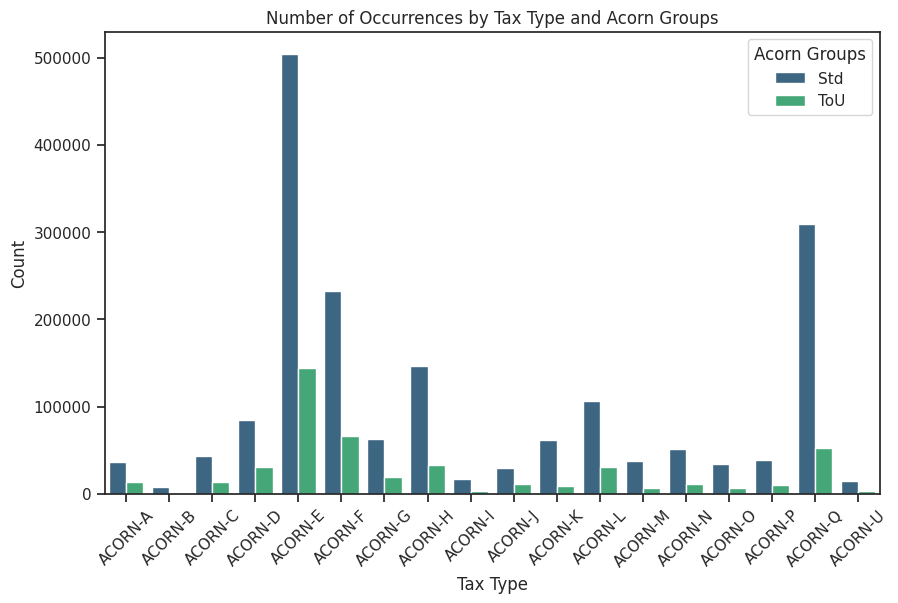

In [40]:
# Ocorrências do tipo de tarifa por cada acorn_group
# Converte o DataFrame PySpark para pandas
df_sample = df.sample(fraction=0.8, seed=42)

try:
    Pandas_df = df.toPandas()
except Exception as e:
    print(f"Erro ao converter para pandas: {e}")

# Contar as ocorrências 
category_value_counts = Pandas_df.groupby(['acorn_groups', 'tax_type']).size().reset_index(name='count')

# Criar o barplot 
plt.figure(figsize=(10, 6))
sns.barplot(x='acorn_groups', y='count', hue='tax_type', data=category_value_counts, palette='viridis')
plt.title('Number of Occurrences by Tax Type and Acorn Groups')
plt.xlabel('Tax Type')
plt.ylabel('Count')
plt.legend(title='Acorn Groups')
plt.xticks(rotation=45)
plt.show()

##### Análise da variável **energy_sum**:

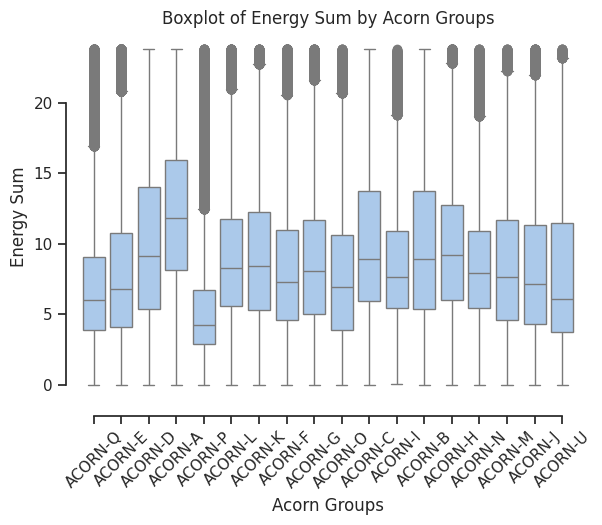

In [41]:
# boxplot para a visualização da variável energy_sum por cada acorn_group
# Converte o DataFrame PySpark para pandas
df_sample = df.sample(fraction=0.7, seed=42)
try:
    Pandas_df = df_sample.toPandas()
except Exception as e:
    print(f"Erro ao converter para pandas: {e}")

sns.set_theme(style="ticks", palette="pastel")

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="acorn_groups", y="energy_sum", data=Pandas_df)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=45)
plt.xlabel("Acorn Groups")
plt.ylabel("Energy Sum")
plt.title("Boxplot of Energy Sum by Acorn Groups")
plt.show()

#boxplot não percetível

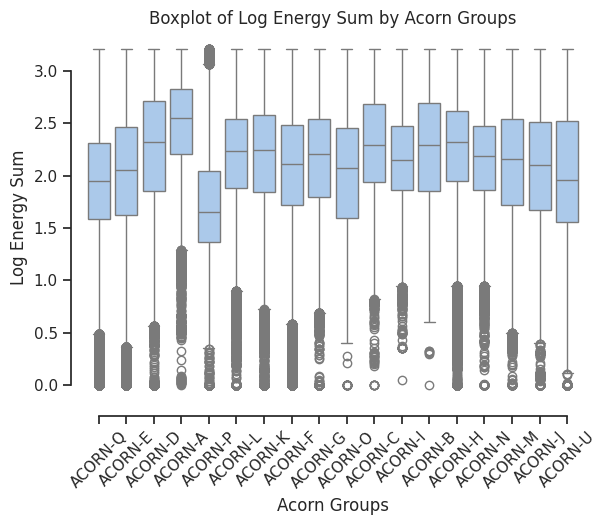

In [42]:
# Boxplots da variável energy_sum logaritmizada, por acorns
# Converter o DataFrame PySpark para pandas
import numpy as np

df_sample = df.sample(fraction=0.7, seed=42)

try:
    Pandas_df = df_sample.toPandas()
except Exception as e:
    print(f"Erro ao converter para pandas: {e}")

# Aplicar a transformação logarítmica à variável 'energy_sum'
Pandas_df['log_energy_sum'] = np.log1p(Pandas_df['energy_sum'])  # Usar log1p para lidar com zeros

# Configurar o tema do seaborn
sns.set_theme(style="ticks", palette="pastel")

# Plotar o boxplot com a variável transformada
sns.boxplot(x="acorn_groups", y="log_energy_sum", data=Pandas_df)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=45)
plt.xlabel("Acorn Groups")
plt.ylabel("Log Energy Sum")
plt.title("Boxplot of Log Energy Sum by Acorn Groups")
plt.show()

# ficam bem mais percetíveis os valores

##### Análise da variável **Energy_mean**:

In [43]:
# Agrupar os dados por grupo ACORN e calcular a média de energy_mean
average_energy_by_acorn = df.groupBy("acorn_groups") \
    .agg(format_number(avg("energy_mean"), 3).alias("average_energy_mean")) \
    .orderBy("average_energy_mean", ascending = False)  # Ordenar em ordem descendente # Ordenar em ordem descendente

# Criar um DataFrame que mapeia cada acorn_groups a seu status_level
status_df = df.groupBy("acorn_groups").agg(first("status").alias("status")).distinct()

# Juntar os DataFrames
final_df = average_energy_by_acorn.join(
    status_df,
    on="acorn_groups",
    how="left"  # Junção à esquerda para manter todas as linhas de average_energy_by_acorn
).orderBy("average_energy_mean", ascending = True)

# Mostrar os resultados com o nível de acesso aos recursos
final_df.show(truncate=False)

+------------+-------------------+-----------+
|acorn_groups|average_energy_mean|status     |
+------------+-------------------+-----------+
|ACORN-P     |0.117              |Adversity  |
|ACORN-Q     |0.146              |Adversity  |
|ACORN-U     |0.163              |ACORN-U    |
|ACORN-O     |0.165              |Adversity  |
|ACORN-E     |0.166              |Affluent   |
|ACORN-F     |0.172              |Comfortable|
|ACORN-J     |0.176              |Comfortable|
|ACORN-N     |0.179              |Adversity  |
|ACORN-I     |0.179              |Comfortable|
|ACORN-M     |0.180              |Adversity  |
|ACORN-G     |0.184              |Comfortable|
|ACORN-L     |0.189              |Adversity  |
|ACORN-K     |0.190              |Adversity  |
|ACORN-H     |0.203              |Comfortable|
|ACORN-B     |0.207              |Affluent   |
|ACORN-D     |0.210              |Affluent   |
|ACORN-C     |0.211              |Affluent   |
|ACORN-A     |0.253              |Affluent   |
+------------

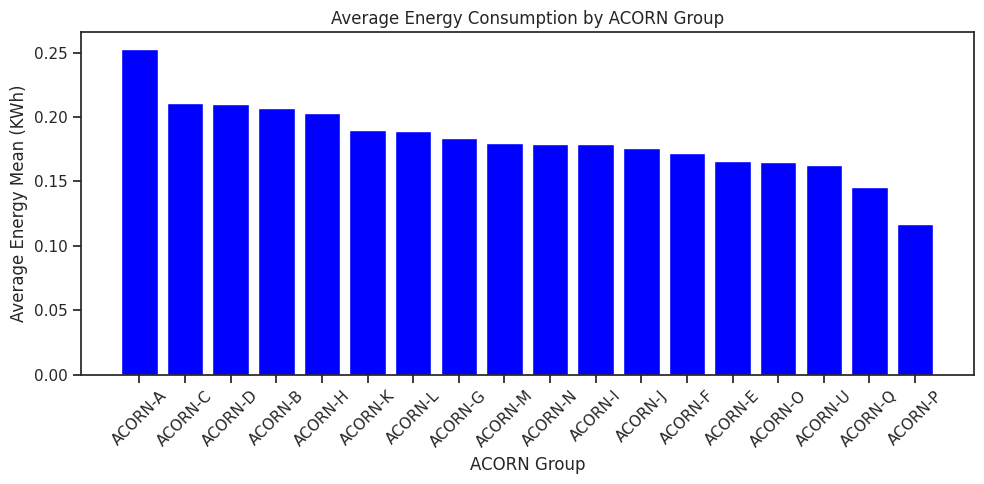

In [44]:
#Visualização

# Adquirir dados do DataFrame PySpark
data = average_energy_by_acorn.collect()

# Preparar dados para o gráfico
acorn_groups = [row['acorn_groups'] for row in data]
average_energy_means = [float(row['average_energy_mean'].replace(',', '')) for row in data]  # Remover vírgulas e converter para float

# Criar o gráfico de barras
plt.figure(figsize=(10, 5))
plt.bar(acorn_groups, average_energy_means, color='blue')
plt.xlabel('ACORN Group')
plt.ylabel('Average Energy Mean (KWh)')
plt.title('Average Energy Consumption by ACORN Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Outliers de **energy_mean** por acorn

In [45]:
# Supondo que df é o DataFrame original
data_for_plot = df.select("acorn_groups", "energy_mean").collect()

# Organizar os dados em um dicionário onde as chaves são os grupos ACORN e os valores são listas de energy_mean
from collections import defaultdict
energy_data = defaultdict(list)
for row in data_for_plot:
    energy_data[row['acorn_groups']].append(row['energy_mean'])

In [46]:
stats = df.groupBy("acorn_groups").agg(
    expr("percentile(energy_mean, 0.25)").alias("Q1"),
    expr("percentile(energy_mean, 0.75)").alias("Q3")
).withColumn("IQR", expr("Q3 - Q1"))

# Agora, juntar de volta ao DataFrame original para calcular os limites para outliers
df_with_outliers = df.join(stats, "acorn_groups")

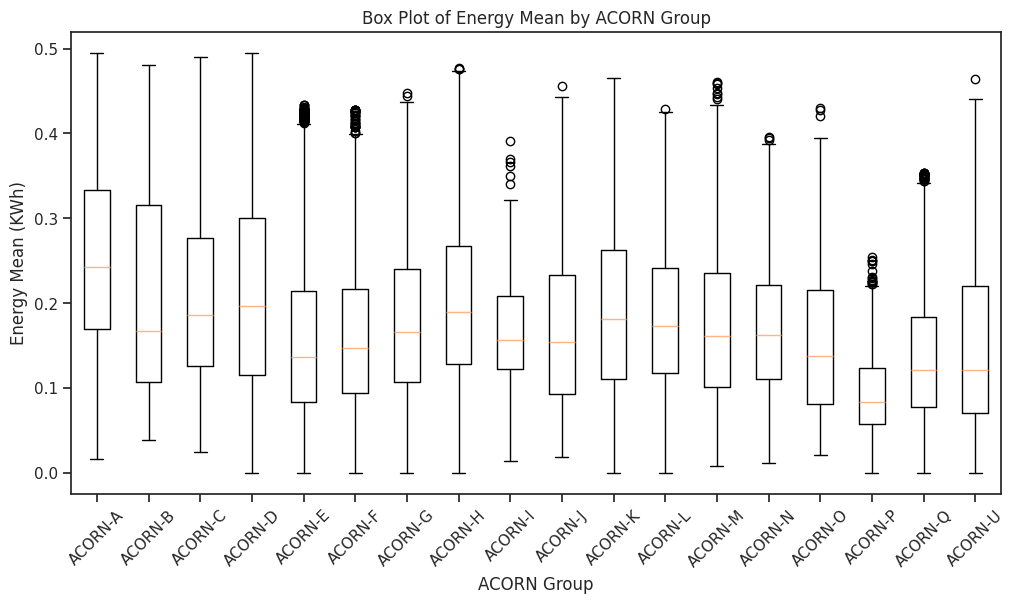

In [47]:
# Calcular os quartis e o IQR para cada grupo ACORN
stats_df = df.groupBy("acorn_groups").agg(
    expr("percentile(energy_mean, 0.25)").alias("Q1"),
    expr("percentile(energy_mean, 0.75)").alias("Q3")
).withColumn("IQR", expr("Q3 - Q1"))

# Calcular os limites inferior e superior para identificar outliers
outlier_bounds = stats_df.withColumn("Lower_Bound", col("Q1") - 1.5 * col("IQR")).withColumn("Upper_Bound", col("Q3") + 1.5 * col("IQR"))

# Adicionar os limites ao DataFrame de estatísticas
stats_with_bounds = stats_df.withColumn("Lower_Bound", col("Q1") - 1.5 * col("IQR")).withColumn("Upper_Bound", col("Q3") + 1.5 * col("IQR"))

# Filtrar outliers para fazer o boxplot
outliers = df.join(stats_with_bounds, "acorn_groups").filter(
    (col("energy_mean") < col("Lower_Bound")) | (col("energy_mean") > col("Upper_Bound"))
).select("acorn_groups", "energy_mean")

# Filtrar dados regulares para fazer o boxplot
regular_data = df.join(stats_with_bounds, "acorn_groups").filter(
    (col("energy_mean") >= col("Lower_Bound")) & (col("energy_mean") <= col("Upper_Bound"))
).select("acorn_groups", "energy_mean")

# Amostrar e coletar dados para reduzir o volume
outliers_sample = outliers.sample(fraction=0.01).collect()  # Ajuste a fração conforme necessário
regular_data_sample = regular_data.sample(fraction=0.01).collect()

# Preparar dados para plotagem
acorn_groups = sorted(set([row['acorn_groups'] for row in regular_data_sample]))
data_to_plot = {group: [row['energy_mean'] for row in regular_data_sample if row['acorn_groups'] == group] for group in acorn_groups}

# Criar box plots
plt.figure(figsize=(12, 6))
plt.boxplot([data_to_plot[group] for group in acorn_groups], labels=acorn_groups)
plt.title('Box Plot of Energy Mean by ACORN Group')
plt.xlabel('ACORN Group')
plt.ylabel('Energy Mean (KWh)')
plt.xticks(rotation=45)
plt.show()

Contagem de outliers por acorn na variável **energy_mean**

In [48]:
# Juntar os limites ao DataFrame original
df_with_bounds = df.join(stats_with_bounds, "acorn_groups")

# Filtrar outliers
outliers = df_with_bounds.filter(
    (col("energy_mean") < col("Lower_Bound")) | (col("energy_mean") > col("Upper_Bound"))
)

# Contar outliers por grupo ACORN
outliers_count = outliers.groupBy("acorn_groups").count()

# Mostrar a contagem de outliers por grupo ACORN
outliers_count.show(truncate=False)

+------------+-----+
|acorn_groups|count|
+------------+-----+
|ACORN-F     |5846 |
|ACORN-N     |1949 |
|ACORN-E     |15979|
|ACORN-Q     |14069|
|ACORN-L     |2668 |
|ACORN-K     |420  |
|ACORN-J     |762  |
|ACORN-M     |564  |
|ACORN-U     |108  |
|ACORN-P     |3741 |
|ACORN-H     |1170 |
|ACORN-G     |1174 |
|ACORN-I     |746  |
|ACORN-O     |813  |
+------------+-----+



In [49]:
# Calcular a contagem total por grupo ACORN
total_count = df.groupBy("acorn_groups").count().alias("total")

# Renomear colunas para evitar ambiguidade
total_count = total_count.withColumnRenamed("count", "total_count")

# Renomear a coluna "count"
outliers_count = outliers_count.withColumnRenamed("count", "outlier_count")

# Juntar a contagem de outliers com a contagem total
outlier_and_total_counts = total_count.join(
    outliers_count,
    on="acorn_groups",
    how="left_outer"  # Usando junção outer para garantir que todos os grupos sejam incluídos
)

# Calcular a percentagem de outliers
outlier_percentages = outlier_and_total_counts.withColumn(
    "outlier_percentage",
    format_number((col("outlier_count") / col("total_count")) * 100, 3)
)

# Verificar as colunas disponíveis e mostrar a percentagem de outliers por grupo ACORN
outlier_percentages.select("acorn_groups", "total_count", "outlier_count", "outlier_percentage").show(truncate=False)

+------------+-----------+-------------+------------------+
|acorn_groups|total_count|outlier_count|outlier_percentage|
+------------+-----------+-------------+------------------+
|ACORN-B     |9203       |NULL         |NULL              |
|ACORN-C     |56343      |NULL         |NULL              |
|ACORN-D     |114427     |NULL         |NULL              |
|ACORN-F     |298920     |5846         |1.956             |
|ACORN-N     |62088      |1949         |3.139             |
|ACORN-E     |649026     |15979        |2.462             |
|ACORN-L     |136328     |2668         |1.957             |
|ACORN-Q     |361264     |14069        |3.894             |
|ACORN-J     |40872      |762          |1.864             |
|ACORN-K     |71051      |420          |0.591             |
|ACORN-M     |43567      |564          |1.295             |
|ACORN-U     |17902      |108          |0.603             |
|ACORN-A     |50220      |NULL         |NULL              |
|ACORN-G     |81829      |1174         |

In [50]:
df_with_outlier_flag = df_with_bounds.withColumn(
    "is_outlier",
    when(
        (col("energy_mean") < col("Lower_Bound")) | (col("energy_mean") > col("Upper_Bound")),
        1
    ).otherwise(0)
)

# Separar as bases de dados com e sem outliers
df_no_outliers = df_with_outlier_flag.filter(col("is_outlier") == 0)
df_only_outliers = df_with_outlier_flag.filter(col("is_outlier") == 1)

# Análise básica para comparar os dois conjuntos
print("Análise sem outliers:")
df_no_outliers.describe("energy_mean").show()

print("Análise apenas com outliers:")
df_only_outliers.describe("energy_mean").show()

Análise sem outliers:
+-------+-------------------+
|summary|        energy_mean|
+-------+-------------------+
|  count|            2231031|
|   mean|0.16854404808239776|
| stddev|0.09795668862196484|
|    min|                0.0|
|    max|              0.495|
+-------+-------------------+

Análise apenas com outliers:
+-------+-------------------+
|summary|        energy_mean|
+-------+-------------------+
|  count|              50009|
|   mean| 0.4393673140728666|
| stddev|0.04621886324184772|
|    min|              0.261|
|    max|              0.495|
+-------+-------------------+



In [51]:
# Calcular Q1, Q3, e IQR
quantiles = df.stat.approxQuantile("energy_mean", [0.25, 0.75], 0)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

# Definir os limites para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar os outliers
df_no_outliers = df.filter((col("energy_mean") >= lower_bound) & (col("energy_mean") <= upper_bound))

# Ver os dados sem outliers
df_no_outliers.show()

+------------+----------+-------------+-----------+----------+----------+----------+----------+--------+------------+-----------+---------+
|household_id|      date|energy_median|energy_mean|energy_max|energy_std|energy_sum|energy_min|tax_type|acorn_groups|     status|is_summer|
+------------+----------+-------------+-----------+----------+----------+----------+----------+--------+------------+-----------+---------+
|   MAC001330|2012-12-31|        0.047|      0.073|      0.21|     0.043|     3.525|     0.046|     Std|     ACORN-Q|  Adversity|        0|
|   MAC003980|2013-06-27|        0.109|      0.101|     0.248|     0.066|     4.839|       0.0|     Std|     ACORN-Q|  Adversity|        1|
|   MAC001993|2012-08-10|        0.077|      0.111|      0.78|     0.125|     5.327|     0.053|     ToU|     ACORN-N|  Adversity|        1|
|   MAC002588|2013-02-25|        0.123|      0.172|     0.388|     0.081|     8.263|     0.065|     Std|     ACORN-E|   Affluent|        0|
|   MAC002479|2013-0

In [52]:
df = df_no_outliers

#### Análise da média do consumo máximo de energia (**energy_max**)

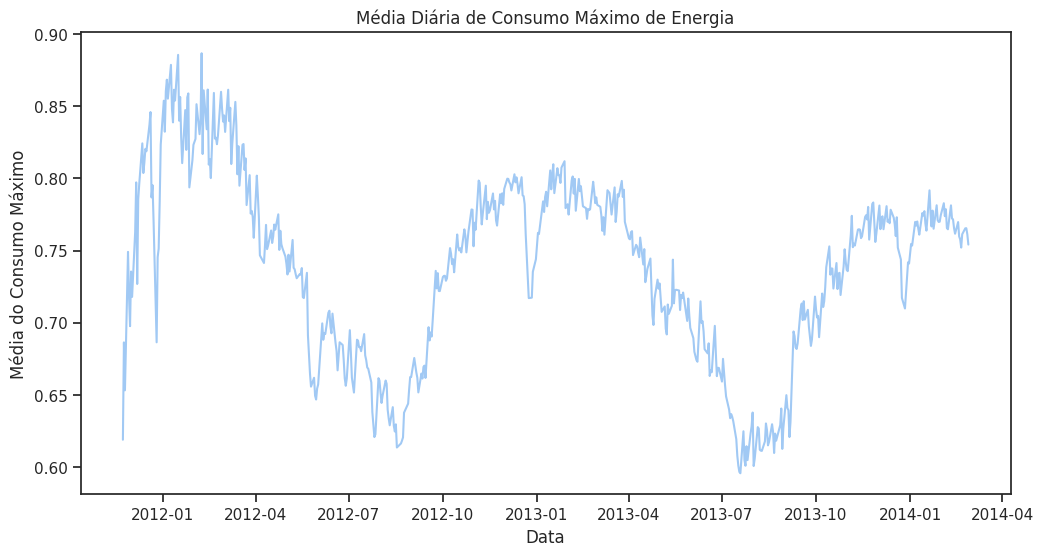

In [53]:
# Agrupar por household e data, e calcular o máximo diário por household
max_per_household_daily = df.groupBy("date", "household_id").agg(F.max("energy_max").alias("max_daily"))

# Agrupar por data e calcular a média dos máximos diários por household
average_max_per_day = max_per_household_daily.groupBy("date").agg(F.mean("max_daily").alias("avg_max_daily"))

# Ordenar por data para visualização correta
average_max_per_day = average_max_per_day.orderBy("date")

# Opcionalmente, colete o resultado e plote usando Pandas/Matplotlib se os dados não forem excessivamente grandes
average_max_per_day_pd = average_max_per_day.toPandas()
average_max_per_day_pd.set_index("date")['avg_max_daily'].plot(figsize=(12, 6), title='Média Diária de Consumo Máximo de Energia')
plt.xlabel('Data')
plt.ylabel('Média do Consumo Máximo')

plt.show()

#### Visualização das diferenças de consumo diário por acorn

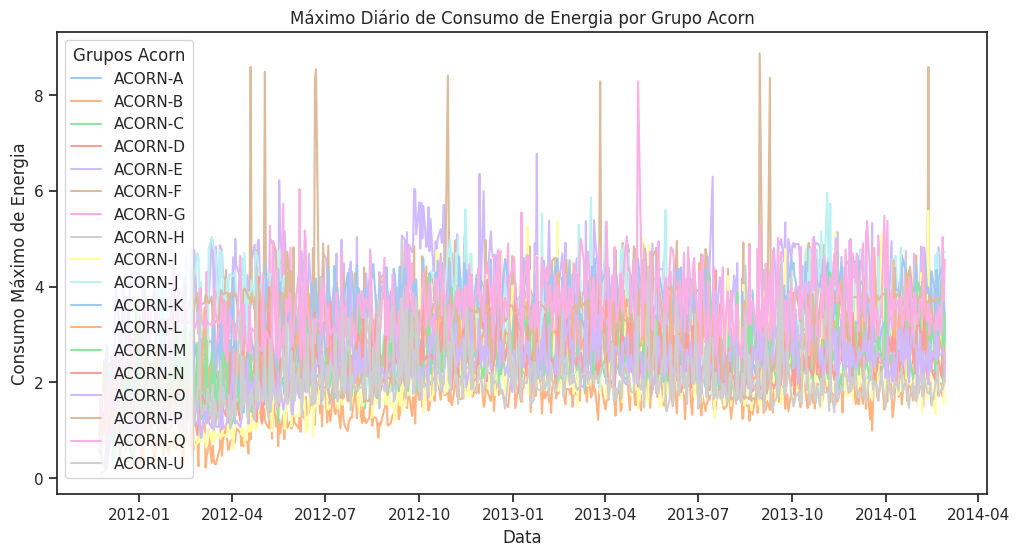

In [54]:
# Agrupar por data e acorn_groups e calcular o máximo diário por grupo
max_daily_by_acorn = df.groupBy("date", "acorn_groups").agg(F.max("energy_max").alias("max_daily"))

# Ordenação dos dados por data 
max_daily_by_acorn = max_daily_by_acorn.orderBy("date", "acorn_groups")
max_daily_by_acorn_pd = max_daily_by_acorn.toPandas()
pivot_df = max_daily_by_acorn_pd.pivot(index='date', columns='acorn_groups', values='max_daily')

# Criação do gráfico dos máximos diários por grupo Acorn
plt.figure(figsize=(12, 6))
for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=column)

plt.title('Máximo Diário de Consumo de Energia por Grupo Acorn')
plt.xlabel('Data')
plt.ylabel('Consumo Máximo de Energia')
plt.legend(title='Grupos Acorn')
plt.show()

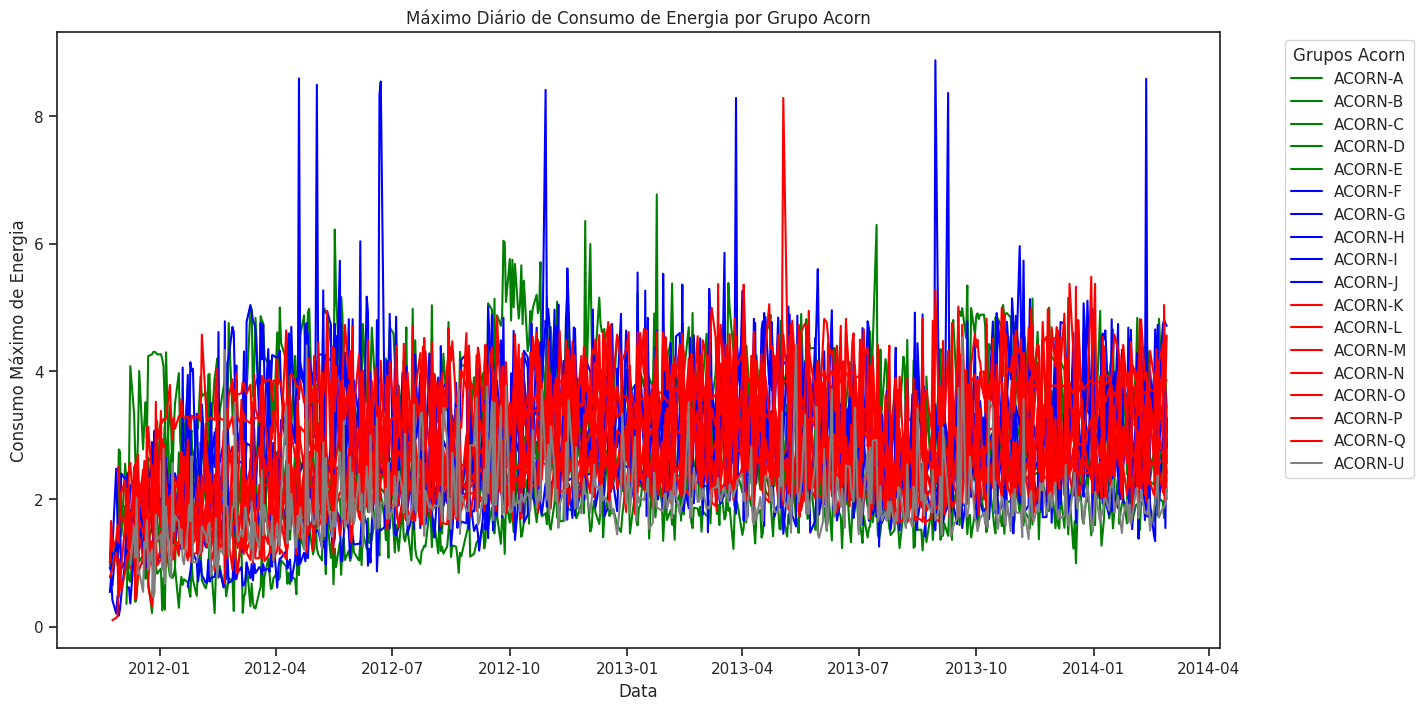

In [56]:
# Agrupar por data e acorn_groups, e calcular o máximo diário por grupo
# Incluindo manter o 'status' utilizando a função `first()`
max_daily_by_acorn = df.groupBy("date", "acorn_groups").agg(
    spark_max("energy_max").alias("max_daily"),
    first("status").alias("status")  # Mantém status
)

# Ordenar por data para facilitar a visualização
max_daily_by_acorn = max_daily_by_acorn.orderBy("date", "acorn_groups")

# Aquirir os dados para plotagem local se o dataset não for muito grande
max_daily_by_acorn_pd = max_daily_by_acorn.toPandas()
pivot_df = max_daily_by_acorn_pd.pivot(index='date', columns='acorn_groups', values='max_daily')

# Cor padrão para grupos sem status 
default_color = 'gray'

# Criar um mapeamento de cores baseado em 'status' disponível no DataFrame
status_colors = {
    'Adversity': 'red',
    'Comfortable': 'blue',
    'Affluent': 'green'
}

# Aplicar cores baseadas no 'status' para cada grupo Acorn, garantindo uma cor padrão
colors = max_daily_by_acorn_pd.groupby('acorn_groups')['status'].first().map(status_colors).fillna(default_color).to_dict()

# Criar um gráfico com as cores corrigidas
plt.figure(figsize=(15, 8))
for column in pivot_df.columns:
    # Usar 'get' com um valor padrão para garantir que sempre haja uma cor válida
    plt.plot(pivot_df.index, pivot_df[column], label=column, color=colors.get(column, default_color))

plt.title('Máximo Diário de Consumo de Energia por Grupo Acorn')
plt.xlabel('Data')
plt.ylabel('Consumo Máximo de Energia')
plt.legend(title='Grupos Acorn', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

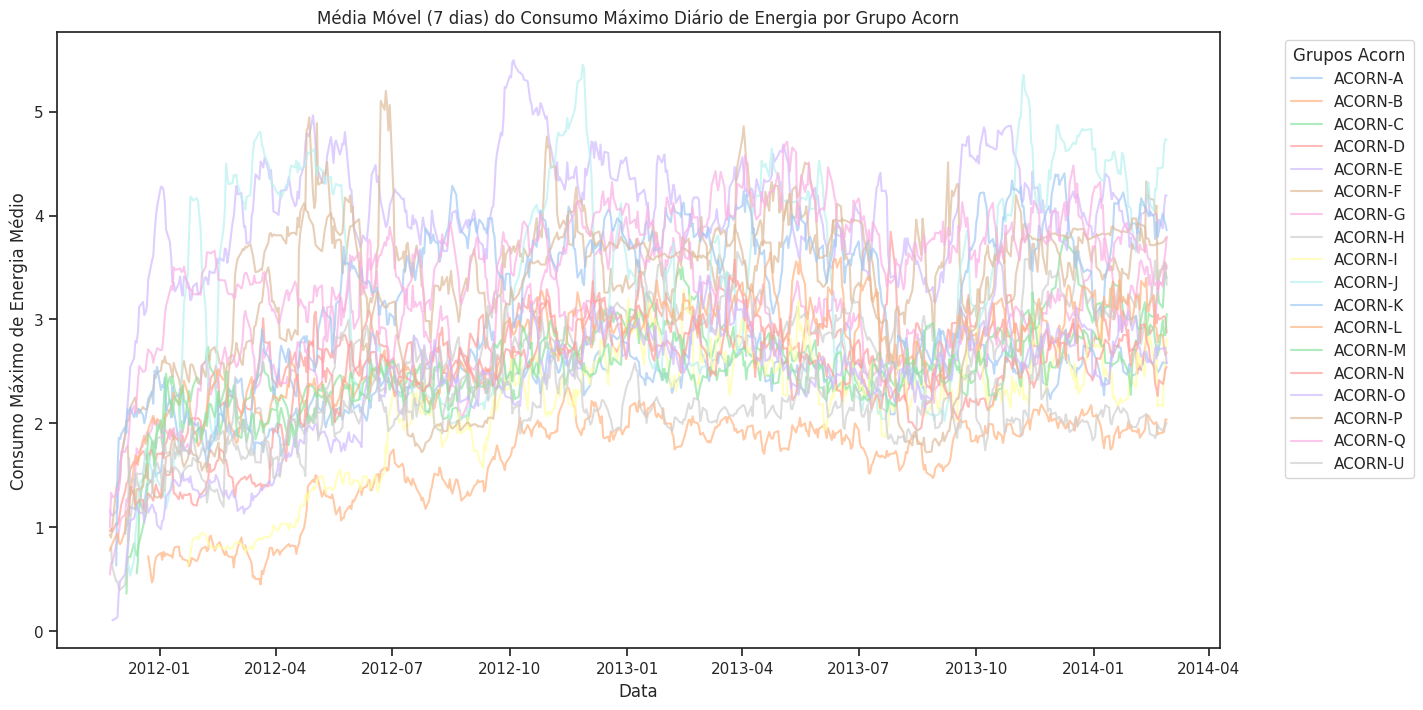

In [ ]:
# Média móvel do consumo méximo diário por acorn
window_length = 7  # Janela de 7 dias para a média móvel

# Calcular a média móvel para cada coluna (cada grupo ACORN)
smoothed_pivot_df = pivot_df.rolling(window=window_length, min_periods=1).mean()

plt.figure(figsize=(15, 8))
for column in smoothed_pivot_df.columns:
    plt.plot(smoothed_pivot_df.index, smoothed_pivot_df[column], label=column, alpha=0.7)

plt.title('Média Móvel (7 dias) do Consumo Máximo Diário de Energia por Grupo Acorn')
plt.xlabel('Data')
plt.ylabel('Consumo Máximo de Energia Médio')
plt.legend(title='Grupos Acorn', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

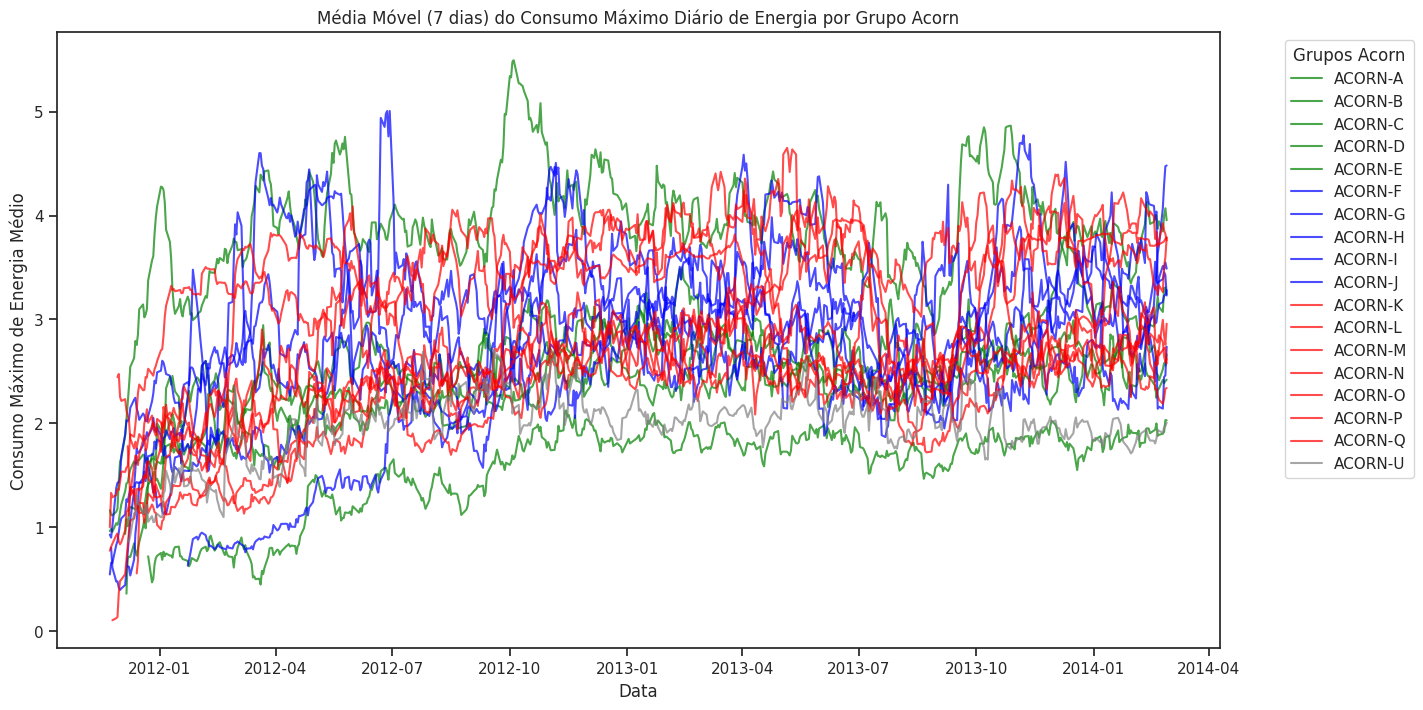

In [57]:
# Mapeamento de cores baseado em 'status', garantindo que todos os grupos tenham uma cor válida
status_colors = {
    'Adversity': 'red',
    'Comfortable': 'blue',
    'Affluent': 'green'
}
default_color = 'gray'  # Cor padrão para grupos sem 'status' 

# Extrair as cores para cada grupo a partir dos dados originais
colors = max_daily_by_acorn_pd.groupby('acorn_groups')['status'].first().map(status_colors).fillna(default_color).to_dict()

window_length = 7  # Janela de 7 dias para a média móvel

# Calcular a média móvel para cada coluna (cada grupo ACORN)
smoothed_pivot_df = pivot_df.rolling(window=window_length, min_periods=1).mean()

# Criação de um gráfico com as médias móveis e com as cores correspondentes
plt.figure(figsize=(15, 8))
for column in smoothed_pivot_df.columns:
    # Usar 'get' com um valor padrão para garantir que sempre haja uma cor válida
    plt.plot(smoothed_pivot_df.index, smoothed_pivot_df[column], label=column, color=colors.get(column, default_color), alpha=0.7)

plt.title('Média Móvel (7 dias) do Consumo Máximo Diário de Energia por Grupo Acorn')
plt.xlabel('Data')
plt.ylabel('Consumo Máximo de Energia Médio')
plt.legend(title='Grupos Acorn', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Correlações

In [ ]:
# Função para obter colunas numéricas no dataframe
def numeric_columns(df):
    cls_numeric = []
    for x, t in df.dtypes:
        if t in ['int', 'double','float']:
            cls_numeric.append(x)
    return cls_numeric

#### Correlações entre variáveis numéricas

In [ ]:
#Correlação de Pearson (entre variáveis numéricas)

#Seleção das colunas numéricas 
cols_num = numeric_columns(df)


#Assemble das colunas selecionadas
vector_col = "corr_features_num"
assembler = VectorAssembler(inputCols=cols_num, outputCol=vector_col, handleInvalid="skip")  
df_vector = assembler.transform(df).select(vector_col)

#Função para calcular a matriz de correlação
def plotCorrelationMatrix(df, annot=False):
    # Criação da matriz de correlação
    corr = df.corr()
    
    # Criar uma máscara para o triângulo
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))

    # Gerar um colormap 
    cmap='coolwarm'

    # Desenhar um heatmap com a máscara e o correto aspeto rácio
    return sns.heatmap(corr, annot=annot,mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#Cálculo e exibição da correlação de Pearson para as primeiras 10 observações
corr_pearson = Correlation.corr(df_vector, vector_col).head()
print("Matriz de correlação de Pearson entre variáveis categóricas:\n" + str(corr_pearson[0]))

#Matriz de correlação de Pearson
corr_pearson_matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray().tolist()
corr_pearson_matrix



Matriz de correlação de Pearson entre variáveis categóricas:
DenseMatrix([[ 1.        ,  0.87528683,  0.43065988,  0.43543893,  0.87387465,
               0.70394354, -0.08989578],
             [ 0.87528683,  1.        ,  0.71722764,  0.77151683,  0.99887993,
               0.63430552, -0.12604859],
             [ 0.43065988,  0.71722764,  1.        ,  0.94468511,  0.71729524,
               0.24156759, -0.10267909],
             [ 0.43543893,  0.77151683,  0.94468511,  1.        ,  0.77127286,
               0.17889722, -0.13442025],
             [ 0.87387465,  0.99887993,  0.71729524,  0.77127286,  1.        ,
               0.63334581, -0.12630599],
             [ 0.70394354,  0.63430552,  0.24156759,  0.17889722,  0.63334581,
               1.        ,  0.01571488],
             [-0.08989578, -0.12604859, -0.10267909, -0.13442025, -0.12630599,
               0.01571488,  1.        ]])


[[1.0,
  0.8752868312521996,
  0.4306598781128772,
  0.43543893498112907,
  0.8738746471023271,
  0.7039435377927682,
  -0.08989577898486982],
 [0.8752868312521996,
  1.0,
  0.7172276448291258,
  0.7715168342789064,
  0.9988799290884529,
  0.6343055177343148,
  -0.12604859263835272],
 [0.4306598781128772,
  0.7172276448291258,
  1.0,
  0.9446851093160663,
  0.7172952415372753,
  0.2415675899007061,
  -0.10267908995837177],
 [0.43543893498112907,
  0.7715168342789064,
  0.9446851093160663,
  1.0,
  0.7712728586288664,
  0.1788972187469843,
  -0.13442024862500812],
 [0.8738746471023271,
  0.9988799290884529,
  0.7172952415372753,
  0.7712728586288664,
  1.0,
  0.6333458079696953,
  -0.1263059871831285],
 [0.7039435377927682,
  0.6343055177343148,
  0.2415675899007061,
  0.1788972187469843,
  0.6333458079696953,
  1.0,
  0.015714879487636325],
 [-0.08989577898486982,
  -0.12604859263835272,
  -0.10267908995837177,
  -0.13442024862500812,
  -0.1263059871831285,
  0.015714879487636325,
  1.

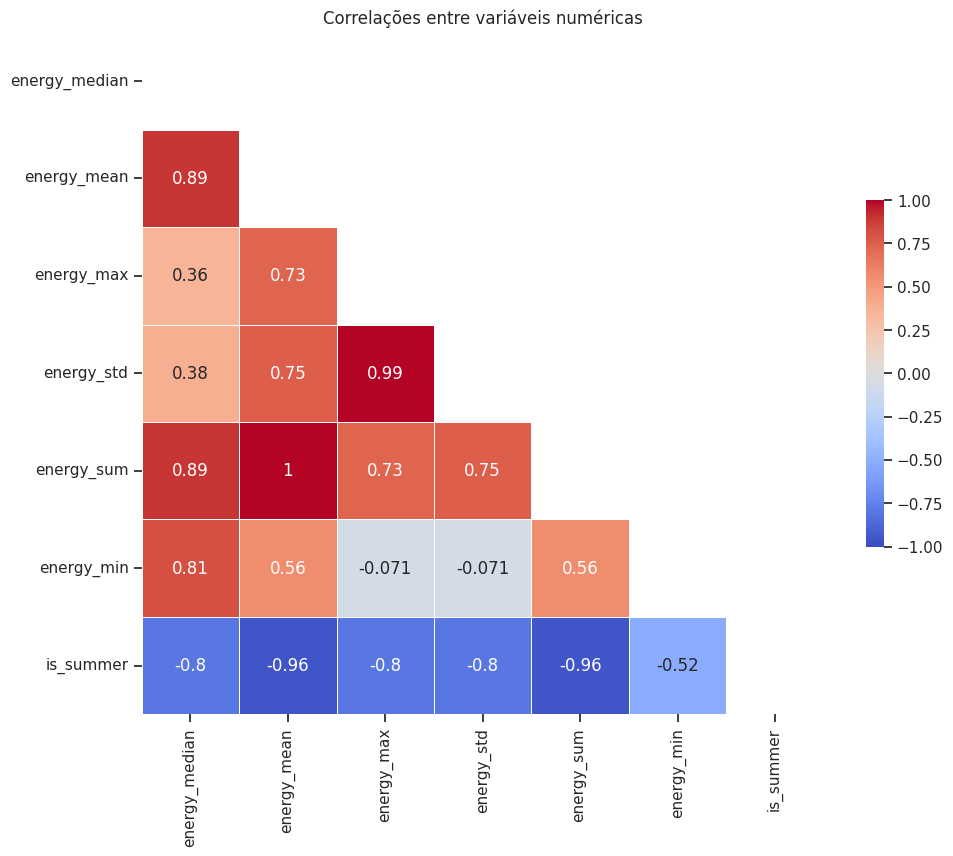

In [ ]:
# Plot das correlações entre variáveis numéricas

plot_corr_pearson = pd.DataFrame(data = corr_pearson_matrix, index=cols_num, columns=cols_num)
plotCorrelationMatrix(plot_corr_pearson, annot=True)
plt.title('Correlações entre variáveis numéricas')
plt.show()

##### Observações

Os pares de variáveis com maiores valores de correlação são:
- **energy_min** com **energy_std** e **energy_max** (-0.91 e -0.93, respetivamente)
- **energy_median** com **energy_min**, **energy_sum**, **energy_max** e **energy_mean** (0.72, 0.78, -0.55 e 0.78 respetivamente)
- **energy_mean** com **energy_sum**
- **energy_max** com **energy_std**

Em conclusão as variáveis mais correlacionadas no geral com as restantes são a **energy_median** e **energy_min**

#### Guardar o novo ficheiro novamente em parquet

In [ ]:
# Criação de partições para aumentar o paralelismo
df_partitioned = df.repartition(200)

In [ ]:
# Salvar as alterações realizadas em parquet
path = '../Datasets/energy_households_parquet.parquet'
df_partitioned.write.mode("overwrite").parquet(path)